In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.ops.tensor_utils import convolve
from scipy.signal import savgol_filter

## Fitting

In [129]:
lineages = torch.load('./Omicron_experimental_data_new.pkl')['lineages']
country = torch.load('./Omicron_experimental_data_new.pkl')['locations']

df_counts_time = pd.read_csv('./4days_date.csv', header = 0)

In [86]:
counts = torch.load('./Omicron_experimental_data_new.pkl')['counts'].sum(1)
counts = counts / (counts.sum(-1).unsqueeze(-1) + 1e-20)
fitting_AE = torch.load('./fitting_AE_world_reparam.pkl', map_location=torch.device('cpu')).data.cpu().squeeze(1)
fitting_NoAE = torch.load('.fitting_noAE_world_reparam.pkl', map_location=torch.device('cpu')).data.cpu().squeeze(1)
fitting_random = torch.load('./fitting_random_world_reparam.pkl', map_location=torch.device('cpu')).data.cpu().squeeze(1)
fitting_NoSite = torch.load('./fitting_noSite_world_reparam.pkl', map_location=torch.device('cpu')).data.cpu().squeeze(1)

In [88]:
def get_lineage_index(list):
    index = []
    for i in range(len(list)):
        index.append(lineages.index(list[i]))
    return index

In [89]:
time = pd.to_datetime(df_counts_time['date'], format='%Y-%m-%d')
lineage = ['BA.2','BA.5.1','BA.5.2.1', 'BQ.1.1','XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1', 'HK.3', 'JN.1']
colors = cm.rainbow(np.arange(len(lineage))/len(lineage))

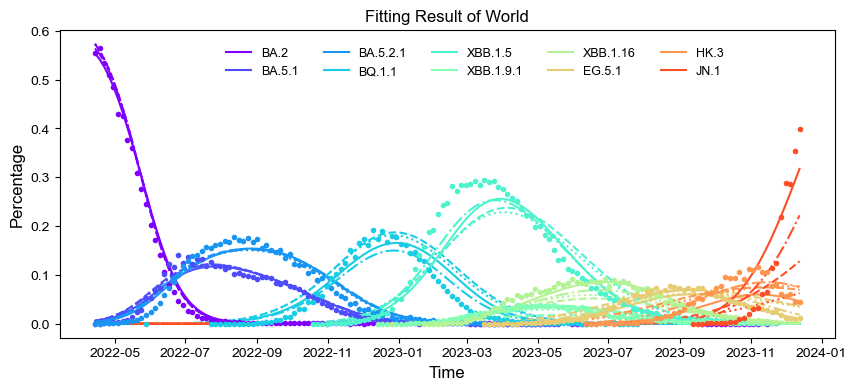

In [90]:
plt.figure(figsize=(10,4))
plt.rcParams['font.sans-serif'] = ['Arial']

def get_counts(lineage_index):
    df_counts = pd.DataFrame(counts[:, lineage_index])
    return df_counts

def get_fitting(lineage_index, fitting):
    df_forecast = pd.DataFrame(fitting[:, lineage_index])
    return df_forecast

start = 41
for i in range(len(lineage)):
    for j in range(len(time[:counts.shape[0]][start:-1])):
        try:
            if get_counts(get_lineage_index(lineage))[start:-1][i][start+j] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+1] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+2] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+3] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+4] !=0:
                plt.plot(time[:counts.shape[0]][start:-1][start+j], get_counts(get_lineage_index(lineage))[start:-1][i][start+j], color = colors[i], lw=0, marker='o', markersize=3)
        except:
            plt.plot(time[:counts.shape[0]][start:-1][start+j], get_counts(get_lineage_index(lineage))[start:-1][i][start+j], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][start:-1], get_fitting(get_lineage_index(lineage), fitting_AE)[start:-1][i], color = colors[i], lw=1.5, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][start:-1], get_fitting(get_lineage_index(lineage), fitting_NoAE)[start:-1][i], color = colors[i], linestyle='--', lw=1.5, zorder=-9)
    plt.plot(time[:counts.shape[0]][start:-1], get_fitting(get_lineage_index(lineage), fitting_random)[start:-1][i], color = colors[i], linestyle='-.', lw=1.5, zorder=-9)
    plt.plot(time[:counts.shape[0]][start:-1], get_fitting(get_lineage_index(lineage), fitting_NoSite)[start:-1][i], color = colors[i], linestyle=':', lw=1.5, zorder=-9)

plt.xlabel('Time', fontsize=12) 
plt.ylabel('Percentage', fontsize=12) 
plt.title('Fitting Result of World')
plt.legend(frameon=False, bbox_to_anchor=(0.2,0.98), fontsize=9, ncol=5)
plt.show()

## Forecast

In [2]:
df_counts_time = pd.read_csv('/Users/leizhongyi/Code/pyro/4days_date.csv', header = 0)
time = pd.to_datetime(df_counts_time['date'], format='%Y-%m-%d')

lineages = torch.load('./data/Omicron_experimental_data_new.pkl')['lineages']
country = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/Omicron_experimental_data_new.pkl')['locations']

counts = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/Omicron_experimental_data_new.pkl')['counts'].sum(1)
counts = counts / (counts.sum(-1).unsqueeze(-1))

counts1 = counts.numpy()
counts = np.nan_to_num(counts1)

In [3]:
j = 40
forecast_result_1 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_noAE_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_2 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_random_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_3 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_noSite_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_4 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_AE_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)

In [4]:
def get_lineage_index(list):
    index = []
    for i in range(len(list)):
        index.append(lineages.index(list[i]))
    return index

In [5]:
## get counts & forecast data
def get_counts(lineage_index):
    df_counts = pd.DataFrame(counts[:, lineage_index])
    return df_counts

def get_forecast(lineage_index, forecast):
    df_forecast = pd.DataFrame(forecast[:,lineage_index].squeeze(1))
    return df_forecast

In [6]:
lineage = ['BA.2','BA.5.1','BA.5.2.1', 'BQ.1.1','XBB.1.5', 'XBB.1.9.1', 'XBB.1.16', 'EG.5.1', 'HK.3', 'JN.1']
colors = cm.rainbow(np.arange(len(lineage))/len(lineage))

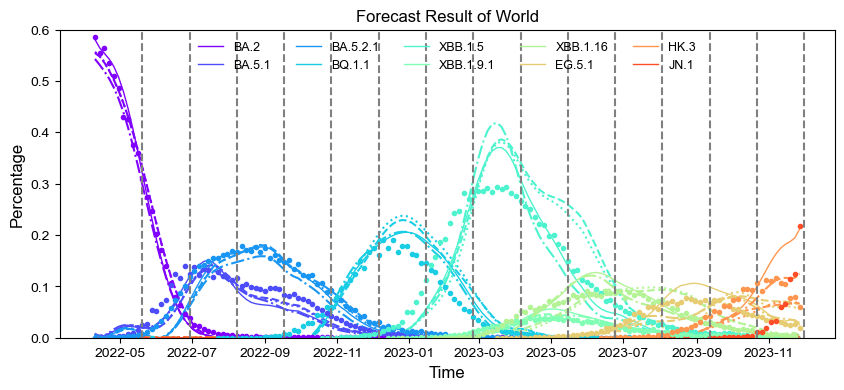

In [7]:
plt.figure(figsize=(10,4))
plt.rcParams['font.sans-serif'] = ['Arial']

start = 40
end = 190
for i in range(len(lineage)):
    for j in range(len(time[:counts.shape[0]][start:end])):
        try:
            if get_counts(get_lineage_index(lineage))[start:-1][i][start+j] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+1] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+2] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+3] !=0 and get_counts(get_lineage_index(lineage))[start:-1][i][start+j+4] !=0:
                plt.plot(time[:counts.shape[0]][start:end][start+j], get_counts(get_lineage_index(lineage))[start:end][i][start+j], color = colors[i], lw=0, marker='o', markersize=3)
        except:
            plt.plot(time[:counts.shape[0]][start:end][start+j], get_counts(get_lineage_index(lineage))[start:end][i][start+j], color = colors[i], lw=0, marker='o', markersize=3)
    plt.plot(time[:counts.shape[0]][start:end], savgol_filter(get_forecast(get_lineage_index(lineage), forecast_result_4)[:counts.shape[0]][start:end][i], 50, 10), color = colors[i], lw=1, zorder=-9, label = lineage[i])
    # plt.plot(time[:counts.shape[0]][start:-1], get_forecast(get_lineage_index(lineage), forecast_result_4)[:counts.shape[0]][start:-1][i], color = colors[i], lw=1.5, zorder=-9, label = lineage[i])
    plt.plot(time[:counts.shape[0]][start:end], savgol_filter(get_forecast(get_lineage_index(lineage), forecast_result_1)[:counts.shape[0]][start:end][i], 50, 10), color = colors[i], linestyle='--', lw=1.5, zorder=-9)
    plt.plot(time[:counts.shape[0]][start:end], savgol_filter(get_forecast(get_lineage_index(lineage), forecast_result_2)[:counts.shape[0]][start:end][i], 50, 10), color = colors[i], linestyle='-.', lw=1.5, zorder=-9)
    plt.plot(time[:counts.shape[0]][start:end], savgol_filter(get_forecast(get_lineage_index(lineage), forecast_result_3)[:counts.shape[0]][start:end][i], 50, 10), color = colors[i], linestyle=':', lw=1.5, zorder=-9)

plt.xlabel('Time', fontsize=12) 
plt.ylabel('Percentage', fontsize=12) 
plt.title('Forecast Result of World')
# plt.legend(frameon=False, bbox_to_anchor=(1.165,1.0),borderaxespad = 0.)
plt.legend(loc= 'upper center', fontsize=9, ncol=5,frameon=False)
for i in range(int((195-43)/10)):
    try:
        plt.axvline(x=time[start+10+10*i],linestyle='--', color='grey')
    except:
        pass
plt.ylim(0,0.6)
plt.show()

## MSE MAE

In [162]:
counts = torch.load('./Omicron_experimental_data_new.pkl')['counts'].sum(1)
true = counts + 1e-20
count = true.sum(-1, True)
true_probs = counts / (counts.sum(-1).unsqueeze(-1)+1e-20)

def loss_cal(model):
    logits = model
    pred = logits[:counts.shape[0]]

    error = (pred - true_probs)  # scaled by Poisson stddev
    mae = error.abs().sum(0)  # average over time
    mse = error.square().sum(0)  # average over time

    return error, mae, mse

In [98]:
print(loss_cal(fitting_AE)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_AE)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_NoAE)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_NoAE)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_random)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_random)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_NoSite)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(fitting_NoSite)[2][get_lineage_index(lineage)].sum().numpy())

10.012632
0.4606652
14.17708
0.92381877
10.126381
0.512634
13.660193
1.0894681


In [165]:
print(loss_cal(forecast_result_4)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_4)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_1)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_1)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_2)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_2)[2][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_3)[1][get_lineage_index(lineage)].sum().numpy())
print(loss_cal(forecast_result_3)[2][get_lineage_index(lineage)].sum().numpy())

12.507287
0.9068398
15.63456
1.3889626
13.15561
0.8787972
15.81651
1.390898


In [10]:
counts = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/Omicron_experimental_data_new.pkl')['counts'].sum(1)
true = counts + 1e-20
count = true.sum(-1, True)
true_probs = counts / (counts.sum(-1).unsqueeze(-1)+1e-20)

def loss_cal(model):
    logits = model
    pred = logits[:counts.shape[0]]

    error = (pred - true_probs)  # scaled by Poisson stddev
    mae = error.abs() # average over time
    mse = error.square()  # average over time

    return error, mae, mse

In [8]:
j = 40
forecast_result_1 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_noAE_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_2 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_random_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_3 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_noSite_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
forecast_result_4 = torch.load('/Users/leizhongyi/Code/pyro/fig3_code/forecast_world/forecast_world_AE_reparam_'+str(j)+'.pkl', map_location=torch.device('cpu')).squeeze(1)
j = j+10

In [11]:
lineage = []
for i in range(true_probs.shape[-1]):
    if true_probs[j:, i].max() > 0.08:
        lineage.append(lineages[i])

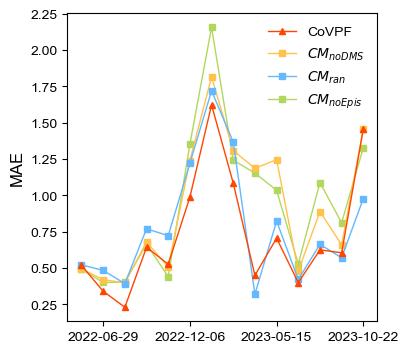

In [12]:
### MAE - prevalent
lineage = ['BA.5','BA.5.2.1','BF.5', 'BF.7','BQ.1','BQ.1.1','XBB','XBB.1.5', 'XBB.1.9.1','XBB.1.16','EG.5.1', 'HK.3','JN.1']
# lineage = ['BA.5','BA.5.2.1','BF.5','BF.7','BQ.1.1','XBB','XBB.1','XBB.1.5', 'XBB.1.9', 'XBB.1.16','EG.5.1', 'HK.3','HV.1','JN.1','JN.1.1']
time_plot = []
mae_loss_AE_p = []
mae_loss_noAE_p = []
mae_loss_ran_p = []
mae_loss_noSite_p = []
for i in range(14):
    time_plot.append(time[:counts.shape[0]][j+10*i].strftime('%Y-%m-%d'))
    mae_loss_AE_p.append(loss_cal(forecast_result_4)[1][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mae_loss_noAE_p.append(loss_cal(forecast_result_1)[1][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mae_loss_ran_p.append(loss_cal(forecast_result_2)[1][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mae_loss_noSite_p.append(loss_cal(forecast_result_3)[1][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
plt.figure(figsize=(4,4))
plt.rcParams['font.sans-serif'] = ['Arial']
plt.plot(time_plot, mae_loss_AE_p, color = '#FF4500', lw=1, zorder=4, label = 'CoVPF',marker='^', markersize=4)
plt.plot(time_plot, mae_loss_noAE_p, color = '#FFC24B', lw=1, zorder=2, label = '$CM_{noDMS}$',marker='s', markersize=4)
plt.plot(time_plot, mae_loss_ran_p, color = '#63B8FF', lw=1, zorder=3, label = '$CM_{ran}$',marker='s', markersize=4)
plt.plot(time_plot, mae_loss_noSite_p, color = '#b1d85c', lw=1, zorder=1, label = '$CM_{noEpis}$',marker='s', markersize=4)
plt.ylabel('MAE', fontsize=12)

plt.xticks([time_plot[1],time_plot[5],time_plot[9],time_plot[13]])
plt.legend(frameon=False)

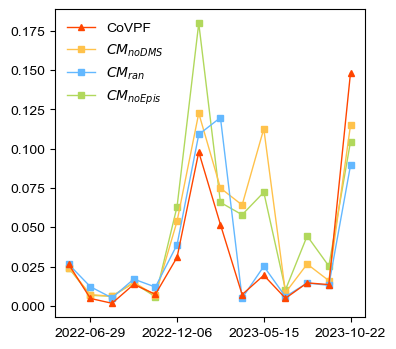

In [13]:
### MSE - prevalent
lineage = ['BA.5','BA.5.2.1','BF.5', 'BF.7','BQ.1','BQ.1.1','XBB','XBB.1.5', 'XBB.1.9.1','XBB.1.16','EG.5.1', 'HK.3','JN.1']
time_plot = []
mse_loss_AE_p = []
mse_loss_noAE_p = []
mse_loss_ran_p = []
mse_loss_noSite_p = []
for i in range(14):
    time_plot.append(time[:counts.shape[0]][j+10*i].strftime('%Y-%m-%d'))
    mse_loss_AE_p.append(loss_cal(forecast_result_4)[2][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mse_loss_noAE_p.append(loss_cal(forecast_result_1)[2][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mse_loss_ran_p.append(loss_cal(forecast_result_2)[2][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
    mse_loss_noSite_p.append(loss_cal(forecast_result_3)[2][:,get_lineage_index(lineage)].sum(-1)[j+10*i:j+10*(i+1)].sum())
plt.figure(figsize=(4,4))
plt.rcParams['font.sans-serif'] = ['Arial']
plt.plot(time_plot, mse_loss_AE_p, color = '#FF4500', lw=1, zorder=4, label = 'CoVPF',marker='^', markersize=4)
plt.plot(time_plot, mse_loss_noAE_p, color = '#FFC24B', lw=1, zorder=2, label = '$CM_{noDMS}$',marker='s', markersize=4)
plt.plot(time_plot, mse_loss_ran_p, color = '#63B8FF', lw=1, zorder=3, label = '$CM_{ran}$',marker='s', markersize=4)
plt.plot(time_plot, mse_loss_noSite_p, color = '#b1d85c', lw=1, zorder=1, label = '$CM_{noEpis}$',marker='s', markersize=4)
plt.xticks([time_plot[1],time_plot[5],time_plot[9],time_plot[13]])
plt.legend(frameon=False)

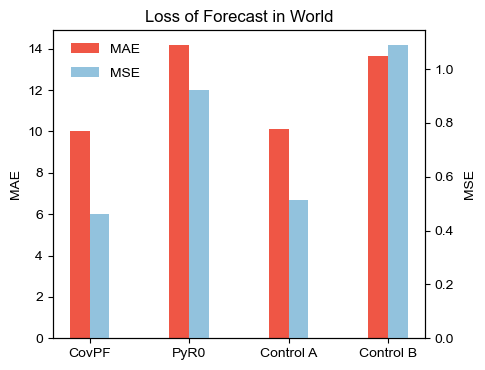

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial']

x_label = ['CovPF', 'PyR0', 'Control A', 'Control B']

# Fitting
sigma_Eu = np.array([10.0126, 14.17708, 10.126381, 13.660193])
sigma_Pu= np.array([0.4606652, 0.92381877, 0.512634, 1.0894681])

# Forecast
# sigma_Eu = [90.574524, 97.38014, 111.28856, 95.86476]
# sigma_Pu= [3.7756739, 4.1430216, 4.7896132, 4.1292214]


bar_width = 0.2 
index_sigma_Eu = np.arange(len(sigma_Eu)) 
index_sigma_Pu = index_sigma_Eu + bar_width 

fig=plt.figure(figsize=(4.8,4))
ax1 = fig.add_subplot(111)
# ax1.axis([0-bar_width, 3.5, 0, 120])
ax1.bar(index_sigma_Eu, height=sigma_Eu, width=bar_width, label='MAE', color = '#EE4431', alpha = 0.9)
ax1.legend(frameon=False,loc=(0.035,0.9))
# ax1.ylim([0, 10000000])
ax1.set_ylabel('MAE')

ax2 = ax1.twinx()
# ax2.axis([0-bar_width, 3.5, 0, 5.5])
ax2.bar(index_sigma_Pu, height=sigma_Pu, width=bar_width, label='MSE', color = '#92C2DD')
ax2.legend(frameon=False,loc=(0.035,0.82))
# ax2.ylim([0, 1500])
ax2.set_ylabel('MSE', labelpad=7)


plt.xticks(index_sigma_Eu + bar_width / 2, x_label)  # 让横坐标轴刻度显示 x_lable中的动作类型， index_x_train + bar_width/2 为横坐标轴刻度的位置
plt.title('Loss of Forecast in World')
plt.show()

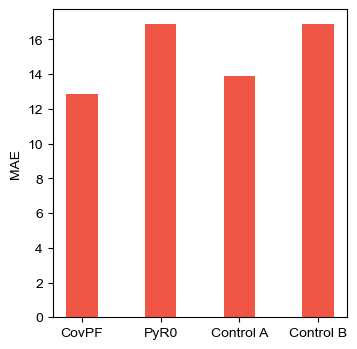

In [125]:
plt.rcParams['font.sans-serif'] = ['Arial']
x_label = ['CovPF', 'PyR0', 'Control A', 'Control B']

# Fitting
# sigma_Eu = np.array([10.0126, 14.17708, 10.126381, 13.660193])
# sigma_Pu= np.array([0.4606652, 0.92381877, 0.512634, 1.0894681])

# Forecast
sigma_Eu = [12.886376, 16.864222, 13.908008, 16.895521]
sigma_Pu = [0.967002, 1.547786, 0.96090275, 1.5517303]

bar_width = 0.2
index_sigma_Eu = np.arange(len(sigma_Eu))/2 
# index_sigma_Pu = index_sigma_Eu + bar_width

fig=plt.figure(figsize=(3.8,4))
ax1 = fig.add_subplot(111)
ax1.bar(index_sigma_Eu, height=sigma_Eu, width=bar_width, color = '#EE4431', alpha = 0.9)
# ax1.bar(index_sigma_Eu, height=np.exp(sigma_Pu), width=bar_width,color = '#92C2DD')
# ax1.legend(frameon=False,loc=(0.05,0.85), fontsize = 8)
# ax1.ylim([0, 10000000])
ax1.set_ylabel('MAE')
# ax1.set_ylabel('MSE')
# ax1.set_xlabel('VOC', fontsize = 8)

# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.xticks(index_sigma_Eu + bar_width/2 -0.1 , x_label)
# plt.xlabel('VOC')
plt.show()

In [126]:
MAE = np.array([10.0126, 14.17708, 10.126381, 13.660193])
MSE = np.array([0.4606652, 0.92381877, 0.512634, 1.0894681])

print((np.abs(MAE[1]-MAE[0])/MAE[1] + np.abs(MAE[2]-MAE[0])/MAE[2] + np.abs(MAE[3]-MAE[0])/MAE[3])/3)
print((np.abs(MSE[1]-MSE[0])/MSE[1] + np.abs(MSE[2]-MSE[0])/MSE[2] + np.abs(MSE[3]-MSE[0])/MSE[3])/3)

0.19066900095677383
0.3932959518744908


## MAE, MSE of country

In [5]:
counts = torch.load('./Omicron_experimental_data_new.pkl')['counts']
true = counts + 1e-20
count = true.sum(-1, True)
true_probs = counts / (counts.sum(-1).unsqueeze(-1)+1e-20)
country = torch.load('./Omicron_experimental_data_new.pkl')['locations']

def loss_cal(model, country):
    logits = model
    pred = logits[:counts.shape[0]]

    error = (pred[:,country,:] - true_probs[:,country,:])  # scaled by Poisson stddev
    mae = error.abs().sum(0)  # average over time
    mse = error.square().sum(0)  # average over time

    return error, mae, mse

In [6]:
country_index = [country.index('USA'),country.index('UnitedKingdom'),country.index('Germany'),country.index('France'),country.index('Brazil')]

In [15]:
fitting_AE = torch.load('./fitting_AE.pkl', map_location=torch.device('cpu'))
fitting_noAE = torch.load('./fitting_noAE.pkl', map_location=torch.device('cpu'))
fitting_random = torch.load('./fitting_random.pkl', map_location=torch.device('cpu'))
fitting_noSite = torch.load('./fitting_noSite.pkl', map_location=torch.device('cpu'))

In [16]:
for i in range(len(country_index)):
    print('country',str(i+1),'AE fitting MAE: ',loss_cal(fitting_AE, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'AE fitting MSE: ',loss_cal(fitting_AE, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'noAE fitting MAE: ',loss_cal(fitting_noAE, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'noAE fitting MSE: ',loss_cal(fitting_noAE, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'random fitting MAE: ',loss_cal(fitting_random, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'random fitting MSE: ',loss_cal(fitting_random, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'noSite fitting MAE: ',loss_cal(fitting_noSite, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'noSite fitting MSE: ',loss_cal(fitting_noSite, country_index[i])[2].sum().numpy())

country 1 AE fitting MAE:  62.351448
country 1 AE fitting MSE:  3.7660892
country 1 noAE fitting MAE:  65.86914
country 1 noAE fitting MSE:  4.1884055
country 1 random fitting MAE:  71.28256
country 1 random fitting MSE:  4.393661
country 1 noSite fitting MAE:  64.18152
country 1 noSite fitting MSE:  4.080897
country 2 AE fitting MAE:  87.01654
country 2 AE fitting MSE:  3.8545024
country 2 noAE fitting MAE:  89.83386
country 2 noAE fitting MSE:  4.0199122
country 2 random fitting MAE:  95.708626
country 2 random fitting MSE:  4.169901
country 2 noSite fitting MAE:  89.39984
country 2 noSite fitting MSE:  3.9713025
country 3 AE fitting MAE:  102.84233
country 3 AE fitting MSE:  6.2946596
country 3 noAE fitting MAE:  103.0549
country 3 noAE fitting MSE:  6.04122
country 3 random fitting MAE:  108.365715
country 3 random fitting MSE:  6.359113
country 3 noSite fitting MAE:  102.01126
country 3 noSite fitting MSE:  5.9801717
country 4 AE fitting MAE:  106.421135
country 4 AE fitting MSE: 

In [17]:
country1_MAE = []
country1_MSE = []
country2_MAE = []
country2_MSE = []
country3_MAE = []
country3_MSE = []
country4_MAE = []
country4_MSE = []
country5_MAE = []
country5_MSE = []

country1_MAE.append(loss_cal(fitting_AE, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(fitting_AE, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(fitting_noAE, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(fitting_noAE, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(fitting_random, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(fitting_random, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(fitting_noSite, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(fitting_noSite, country_index[0])[2].sum().numpy())

country2_MAE.append(loss_cal(fitting_AE, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(fitting_AE, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(fitting_noAE, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(fitting_noAE, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(fitting_random, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(fitting_random, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(fitting_noSite, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(fitting_noSite, country_index[1])[2].sum().numpy())

country3_MAE.append(loss_cal(fitting_AE, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(fitting_AE, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(fitting_noAE, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(fitting_noAE, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(fitting_random, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(fitting_random, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(fitting_noSite, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(fitting_noSite, country_index[2])[2].sum().numpy())

country4_MAE.append(loss_cal(fitting_AE, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(fitting_AE, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(fitting_noAE, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(fitting_noAE, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(fitting_random, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(fitting_random, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(fitting_noSite, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(fitting_noSite, country_index[3])[2].sum().numpy())

country5_MAE.append(loss_cal(fitting_AE, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(fitting_AE, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(fitting_noAE, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(fitting_noAE, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(fitting_random, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(fitting_random, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(fitting_noSite, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(fitting_noSite, country_index[4])[2].sum().numpy())

In [18]:
print((np.abs(country1_MAE[1]-country1_MAE[0])/country1_MAE[1] + np.abs(country1_MAE[2]-country1_MAE[0])/country1_MAE[2] + np.abs(country1_MAE[3]-country1_MAE[0])/country1_MAE[3])/3)
print((np.abs(country1_MSE[1]-country1_MSE[0])/country1_MSE[1] + np.abs(country1_MSE[2]-country1_MSE[0])/country1_MSE[2] + np.abs(country1_MSE[3]-country1_MSE[0])/country1_MSE[3])/3)

print((np.abs(country2_MAE[1]-country2_MAE[0])/country2_MAE[1] + np.abs(country2_MAE[2]-country2_MAE[0])/country2_MAE[2] + np.abs(country2_MAE[3]-country2_MAE[0])/country2_MAE[3])/3)
print((np.abs(country2_MSE[1]-country2_MSE[0])/country2_MSE[1] + np.abs(country2_MSE[2]-country2_MSE[0])/country2_MSE[2] + np.abs(country2_MSE[3]-country2_MSE[0])/country2_MSE[3])/3)

print((np.abs(country3_MAE[1]-country3_MAE[0])/country3_MAE[1] + np.abs(country3_MAE[2]-country3_MAE[0])/country3_MAE[2] + np.abs(country3_MAE[3]-country3_MAE[0])/country3_MAE[3])/3)
print((np.abs(country3_MSE[1]-country3_MSE[0])/country3_MSE[1] + np.abs(country3_MSE[2]-country3_MSE[0])/country3_MSE[2] + np.abs(country3_MSE[3]-country3_MSE[0])/country3_MSE[3])/3)

print((np.abs(country4_MAE[1]-country4_MAE[0])/country4_MAE[1] + np.abs(country4_MAE[2]-country4_MAE[0])/country4_MAE[2] + np.abs(country4_MAE[3]-country4_MAE[0])/country4_MAE[3])/3)
print((np.abs(country4_MSE[1]-country4_MSE[0])/country4_MSE[1] + np.abs(country4_MSE[2]-country4_MSE[0])/country4_MSE[2] + np.abs(country4_MSE[3]-country4_MSE[0])/country4_MSE[3])/3)

print((np.abs(country5_MAE[1]-country5_MAE[0])/country5_MAE[1] + np.abs(country5_MAE[2]-country5_MAE[0])/country5_MAE[2] + np.abs(country5_MAE[3]-country5_MAE[0])/country5_MAE[3])/3)
print((np.abs(country5_MSE[1]-country5_MSE[0])/country5_MSE[1] + np.abs(country5_MSE[2]-country5_MSE[0])/country5_MSE[2] + np.abs(country5_MSE[3]-country5_MSE[0])/country5_MSE[3])/3) 

0.06906998157501221
0.10693578918774922
0.04961285491784414
0.04873184859752655
0.02039312819639842
0.03489192326863607
0.030903175473213196
0.030102834105491638
0.025815290709336598
0.05437775949637095


In [8]:
forecast_AE = torch.load('./10phase_AE.pkl', map_location=torch.device('cpu'))
forecast_noAE = torch.load('./10phase_noAE.pkl', map_location=torch.device('cpu'))
forecast_random = torch.load('./10phase_random.pkl', map_location=torch.device('cpu'))
forecast_noSite = torch.load('./10phase_noSite.pkl', map_location=torch.device('cpu'))

In [9]:
for i in range(len(country_index)):
    print('country',str(i+1),'AE forecast MAE: ',loss_cal(forecast_AE, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'AE forecast MSE: ',loss_cal(forecast_AE, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'noAE forecast MAE: ',loss_cal(forecast_noAE, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'noAE forecast MSE: ',loss_cal(forecast_noAE, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'random forecast MAE: ',loss_cal(forecast_random, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'random forecast MSE: ',loss_cal(forecast_random, country_index[i])[2].sum().numpy())
    print('country',str(i+1),'noSite fitting MAE: ',loss_cal(forecast_noSite, country_index[i])[1].sum().numpy())
    print('country',str(i+1),'noSite fitting MSE: ',loss_cal(forecast_noSite, country_index[i])[2].sum().numpy())

country 1 AE forecast MAE:  85.19667
country 1 AE forecast MSE:  5.3862233
country 1 noAE forecast MAE:  91.79214
country 1 noAE forecast MSE:  6.3092666
country 1 random forecast MAE:  96.95427
country 1 random forecast MSE:  6.696755
country 1 noSite fitting MAE:  90.98014
country 1 noSite fitting MSE:  6.4009933
country 2 AE forecast MAE:  110.72348
country 2 AE forecast MSE:  5.035471
country 2 noAE forecast MAE:  118.64709
country 2 noAE forecast MSE:  5.612161
country 2 random forecast MAE:  122.65338
country 2 random forecast MSE:  5.6929517
country 2 noSite fitting MAE:  118.66103
country 2 noSite fitting MSE:  5.5865707
country 3 AE forecast MAE:  123.51294
country 3 AE forecast MSE:  7.718135
country 3 noAE forecast MAE:  128.03226
country 3 noAE forecast MSE:  7.6987867
country 3 random forecast MAE:  131.38075
country 3 random forecast MSE:  7.721717
country 3 noSite fitting MAE:  127.61803
country 3 noSite fitting MSE:  7.857513
country 4 AE forecast MAE:  126.32245
countr

In [13]:
country1_MAE = []
country1_MSE = []
country2_MAE = []
country2_MSE = []
country3_MAE = []
country3_MSE = []
country4_MAE = []
country4_MSE = []
country5_MAE = []
country5_MSE = []

country1_MAE.append(loss_cal(forecast_AE, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(forecast_AE, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(forecast_noAE, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(forecast_noAE, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(forecast_random, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(forecast_random, country_index[0])[2].sum().numpy())
country1_MAE.append(loss_cal(forecast_noSite, country_index[0])[1].sum().numpy())
country1_MSE.append(loss_cal(forecast_noSite, country_index[0])[2].sum().numpy())

country2_MAE.append(loss_cal(forecast_AE, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(forecast_AE, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(forecast_noAE, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(forecast_noAE, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(forecast_random, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(forecast_random, country_index[1])[2].sum().numpy())
country2_MAE.append(loss_cal(forecast_noSite, country_index[1])[1].sum().numpy())
country2_MSE.append(loss_cal(forecast_noSite, country_index[1])[2].sum().numpy())

country3_MAE.append(loss_cal(forecast_AE, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(forecast_AE, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(forecast_noAE, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(forecast_noAE, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(forecast_random, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(forecast_random, country_index[2])[2].sum().numpy())
country3_MAE.append(loss_cal(forecast_noSite, country_index[2])[1].sum().numpy())
country3_MSE.append(loss_cal(forecast_noSite, country_index[2])[2].sum().numpy())

country4_MAE.append(loss_cal(forecast_AE, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(forecast_AE, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(forecast_noAE, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(forecast_noAE, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(forecast_random, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(forecast_random, country_index[3])[2].sum().numpy())
country4_MAE.append(loss_cal(forecast_noSite, country_index[3])[1].sum().numpy())
country4_MSE.append(loss_cal(forecast_noSite, country_index[3])[2].sum().numpy())

country5_MAE.append(loss_cal(forecast_AE, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(forecast_AE, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(forecast_noAE, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(forecast_noAE, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(forecast_random, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(forecast_random, country_index[4])[2].sum().numpy())
country5_MAE.append(loss_cal(forecast_noSite, country_index[4])[1].sum().numpy())
country5_MSE.append(loss_cal(forecast_noSite, country_index[4])[2].sum().numpy())

In [14]:
print((np.abs(country1_MAE[1]-country1_MAE[0])/country1_MAE[1] + np.abs(country1_MAE[2]-country1_MAE[0])/country1_MAE[2] + np.abs(country1_MAE[3]-country1_MAE[0])/country1_MAE[3])/3)
print((np.abs(country1_MSE[1]-country1_MSE[0])/country1_MSE[1] + np.abs(country1_MSE[2]-country1_MSE[0])/country1_MSE[2] + np.abs(country1_MSE[3]-country1_MSE[0])/country1_MSE[3])/3)

print((np.abs(country2_MAE[1]-country2_MAE[0])/country2_MAE[1] + np.abs(country2_MAE[2]-country2_MAE[0])/country2_MAE[2] + np.abs(country2_MAE[3]-country2_MAE[0])/country2_MAE[3])/3)
print((np.abs(country2_MSE[1]-country2_MSE[0])/country2_MSE[1] + np.abs(country2_MSE[2]-country2_MSE[0])/country2_MSE[2] + np.abs(country2_MSE[3]-country2_MSE[0])/country2_MSE[3])/3)

print((np.abs(country3_MAE[1]-country3_MAE[0])/country3_MAE[1] + np.abs(country3_MAE[2]-country3_MAE[0])/country3_MAE[2] + np.abs(country3_MAE[3]-country3_MAE[0])/country3_MAE[3])/3)
print((np.abs(country3_MSE[1]-country3_MSE[0])/country3_MSE[1] + np.abs(country3_MSE[2]-country3_MSE[0])/country3_MSE[2] + np.abs(country3_MSE[3]-country3_MSE[0])/country3_MSE[3])/3)

print((np.abs(country4_MAE[1]-country4_MAE[0])/country4_MAE[1] + np.abs(country4_MAE[2]-country4_MAE[0])/country4_MAE[2] + np.abs(country4_MAE[3]-country4_MAE[0])/country4_MAE[3])/3)
print((np.abs(country4_MSE[1]-country4_MSE[0])/country4_MSE[1] + np.abs(country4_MSE[2]-country4_MSE[0])/country4_MSE[2] + np.abs(country4_MSE[3]-country4_MSE[0])/country4_MSE[3])/3)

print((np.abs(country5_MAE[1]-country5_MAE[0])/country5_MAE[1] + np.abs(country5_MAE[2]-country5_MAE[0])/country5_MAE[2] + np.abs(country5_MAE[3]-country5_MAE[0])/country5_MAE[3])/3)
print((np.abs(country5_MSE[1]-country5_MSE[0])/country5_MSE[1] + np.abs(country5_MSE[2]-country5_MSE[0])/country5_MSE[2] + np.abs(country5_MSE[3]-country5_MSE[0])/country5_MSE[3])/3) 

0.08556340138117473
0.16684311628341675
0.0769802729288737
0.10563158988952637
0.042450278997421265
0.006905073300004005
0.05145657559235891
0.09267402688662212
0.03290054202079773
0.034942761063575745
